#데이터 출처: 22-2 머신러닝과 산업응용 과제 1

주어진 데이터는 서울시 공공데이터인 자전거 대여 수를 나타낸 데이터로 아래와 같다. 데이터에는 자전거 대여 수와 함께 ID, 시간, 날씨 등의 정보를 포함하고 있다. 데이터의 형태는 아래 그림과 같다. Regression model을 통해 자전거 대여 수를 예측하는 것을 목표로 한다.  

## 필요한 라이브러리 불러오기

In [1]:
import os
import numpy as np
import random
import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn import metrics
import matplotlib.pyplot as plt
import itertools
import time
import statsmodels.api as sm
import statsmodels.formula.api as smf
import seaborn as sns
from sklearn.metrics import accuracy_score,f1_score,precision_score,recall_score
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier


#이외의 필요한 라이브러리 불러오시오


In [2]:
def seed_everything(seed):
    random.seed(seed)
    np.random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
seed_everything(0)

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# 1. 회귀문제

## 데이터 불러오기

In [4]:
regression_df = pd.read_csv('/content/drive/MyDrive/case study/regression.csv')

In [5]:
regression_df.head()

,id,hour,hour_bef_temperature,hour_bef_precipitation,hour_bef_windspeed,hour_bef_humidity,hour_bef_visibility,hour_bef_ozone,hour_bef_pm10,hour_bef_pm2.5,count
0,3,20,16.3,1.0,1.5,89.0,576.0,0.027,76.0,33.0,49.0
1,6,13,20.1,0.0,1.4,48.0,916.0,0.042,73.0,40.0,159.0
2,7,6,13.9,0.0,0.7,79.0,1382.0,0.033,32.0,19.0,26.0
3,8,23,8.1,0.0,2.7,54.0,946.0,0.040,75.0,64.0,57.0
4,9,18,29.5,0.0,4.8,7.0,2000.0,0.057,27.0,11.0,431.0


## 1-1) 데이터전처리

#### 1. null값 10개 미만 : 최빈값으로 대체 (동일한 개수의 최빈값이 있으면 더 작은 값 선택)


In [6]:
regression_df.isnull().sum()

id                          0
hour                        0
hour_bef_temperature        2
hour_bef_precipitation      2
hour_bef_windspeed          9
hour_bef_humidity           2
hour_bef_visibility         2
hour_bef_ozone             76
hour_bef_pm10              90
hour_bef_pm2.5            117
count                       0
dtype: int64

In [7]:
# key: column name, value: is_na_cnt인 dictionary 생성
na_cnt_dict = {}
# key: column name, value: is_na인 row
na_row ={}
for i in regression_df.columns:
  na_row.update({i:[]})
  cnt = 0
  for j in range(len(regression_df[i])):
    if regression_df[i].isna()[j]==True:
      cnt+=1
      na_row[i].append(j)
  na_cnt_dict.update({i:cnt})
print(na_cnt_dict)
print(na_row)

{'id': 0, 'hour': 0, 'hour_bef_temperature': 2, 'hour_bef_precipitation': 2, 'hour_bef_windspeed': 9, 'hour_bef_humidity': 2, 'hour_bef_visibility': 2, 'hour_bef_ozone': 76, 'hour_bef_pm10': 90, 'hour_bef_pm2.5': 117, 'count': 0}
{'id': [], 'hour': [], 'hour_bef_temperature': [934, 1035], 'hour_bef_precipitation': [934, 1035], 'hour_bef_windspeed': [18, 244, 260, 376, 780, 934, 1035, 1138, 1229], 'hour_bef_humidity': [934, 1035], 'hour_bef_visibility': [934, 1035], 'hour_bef_ozone': [14, 44, 46, 84, 122, 140, 142, 147, 158, 176, 222, 236, 244, 265, 289, 317, 324, 331, 356, 422, 429, 451, 463, 466, 472, 479, 507, 532, 537, 554, 576, 579, 589, 595, 623, 624, 631, 645, 649, 660, 686, 698, 708, 728, 745, 763, 778, 796, 811, 861, 868, 876, 897, 934, 957, 970, 1024, 1035, 1070, 1100, 1120, 1142, 1154, 1156, 1165, 1168, 1186, 1211, 1221, 1273, 1278, 1283, 1322, 1329, 1361, 1391], 'hour_bef_pm10': [14, 46, 84, 100, 129, 140, 142, 147, 158, 169, 176, 222, 236, 244, 265, 289, 317, 324, 331, 344,

In [8]:
# dictionary에서 count가 10 미만일 경우에는 na_row에서 해당 row들을 불러와서 df update
for column_name in regression_df.columns:
  mod = regression_df[column_name].mode()
  if na_cnt_dict[column_name]<10:
    for row_num in na_row[column_name]:
      regression_df[column_name][row_num] = mod

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


#### 2. null값 10개 이상 100개 미만 : 평균값으로 대체


In [9]:
for column_name in regression_df.columns:
  mean = regression_df[column_name].mean()
  if 10<=na_cnt_dict[column_name]<100:
    regression_df[column_name] = regression_df[column_name].mean()

#### 3. null값 100개 이상 : null값 행 제거 


In [10]:
for column_name in regression_df.columns:
  if 100<=na_cnt_dict[column_name]:
    for row_num in na_row[column_name]:
      regression_df=regression_df.drop(labels = row_num, axis=0)

In [11]:
regression_df.head()

,id,hour,hour_bef_temperature,hour_bef_precipitation,hour_bef_windspeed,hour_bef_humidity,hour_bef_visibility,hour_bef_ozone,hour_bef_pm10,hour_bef_pm2.5,count
0,3,20,16.3,1.0,1.5,89.0,576.0,0.039149,57.168736,33.0,49.0
1,6,13,20.1,0.0,1.4,48.0,916.0,0.039149,57.168736,40.0,159.0
2,7,6,13.9,0.0,0.7,79.0,1382.0,0.039149,57.168736,19.0,26.0
3,8,23,8.1,0.0,2.7,54.0,946.0,0.039149,57.168736,64.0,57.0
4,9,18,29.5,0.0,4.8,7.0,2000.0,0.039149,57.168736,11.0,431.0


In [12]:
regression_df.isnull().sum()

id                        0
hour                      0
hour_bef_temperature      0
hour_bef_precipitation    0
hour_bef_windspeed        0
hour_bef_humidity         0
hour_bef_visibility       0
hour_bef_ozone            0
hour_bef_pm10             0
hour_bef_pm2.5            0
count                     0
dtype: int64

#### 4. id 변수 제거


In [13]:
regression_df=regression_df.drop(['id'], axis=1)

In [14]:
regression_df

,hour,hour_bef_temperature,hour_bef_precipitation,hour_bef_windspeed,hour_bef_humidity,hour_bef_visibility,hour_bef_ozone,hour_bef_pm10,hour_bef_pm2.5,count
0,20,16.3,1.0,1.5,89.0,576.0,0.039149,57.168736,33.0,49.0
1,13,20.1,0.0,1.4,48.0,916.0,0.039149,57.168736,40.0,159.0
2,6,13.9,0.0,0.7,79.0,1382.0,0.039149,57.168736,19.0,26.0
3,23,8.1,0.0,2.7,54.0,946.0,0.039149,57.168736,64.0,57.0
4,18,29.5,0.0,4.8,7.0,2000.0,0.039149,57.168736,11.0,431.0
...,...,...,...,...,...,...,...,...,...,...
1454,4,16.8,0.0,1.6,53.0,2000.0,0.039149,57.168736,27.0,21.0
1455,3,10.8,0.0,3.8,45.0,2000.0,0.039149,57.168736,19.0,20.0
1456,5,18.3,0.0,1.9,54.0,2000.0,0.039149,57.168736,21.0,22.0
1457,21,20.7,0.0,3.7,37.0,1395.0,0.039149,57.168736,36.0,216.0


#### 5. 전처리 후 index를 0부터 차례로 재정렬 진행


In [15]:
regression_df=regression_df.reset_index()

In [16]:
regression_df = regression_df.drop(['index'], axis =1)

In [17]:
regression_df

,hour,hour_bef_temperature,hour_bef_precipitation,hour_bef_windspeed,hour_bef_humidity,hour_bef_visibility,hour_bef_ozone,hour_bef_pm10,hour_bef_pm2.5,count
0,20,16.3,1.0,1.5,89.0,576.0,0.039149,57.168736,33.0,49.0
1,13,20.1,0.0,1.4,48.0,916.0,0.039149,57.168736,40.0,159.0
2,6,13.9,0.0,0.7,79.0,1382.0,0.039149,57.168736,19.0,26.0
3,23,8.1,0.0,2.7,54.0,946.0,0.039149,57.168736,64.0,57.0
4,18,29.5,0.0,4.8,7.0,2000.0,0.039149,57.168736,11.0,431.0
...,...,...,...,...,...,...,...,...,...,...
1337,4,16.8,0.0,1.6,53.0,2000.0,0.039149,57.168736,27.0,21.0
1338,3,10.8,0.0,3.8,45.0,2000.0,0.039149,57.168736,19.0,20.0
1339,5,18.3,0.0,1.9,54.0,2000.0,0.039149,57.168736,21.0,22.0
1340,21,20.7,0.0,3.7,37.0,1395.0,0.039149,57.168736,36.0,216.0


In [18]:
regression_df.isnull().sum()

hour                      0
hour_bef_temperature      0
hour_bef_precipitation    0
hour_bef_windspeed        0
hour_bef_humidity         0
hour_bef_visibility       0
hour_bef_ozone            0
hour_bef_pm10             0
hour_bef_pm2.5            0
count                     0
dtype: int64

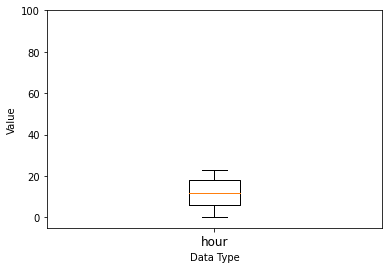

In [32]:
fig, ax = plt.subplots()
ax.boxplot([regression_df['hour']])
ax.set_ylim(-5, 100)
ax.set_xlabel('Data Type')
ax.set_ylabel('Value')
ax.set_xticklabels(['hour'], fontsize=12)

plt.show()

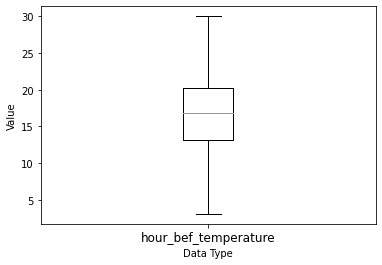

In [33]:
fig, ax = plt.subplots()
ax.boxplot([regression_df['hour_bef_temperature']])
ax.set_xlabel('Data Type')
ax.set_ylabel('Value')
ax.set_xticklabels(['hour_bef_temperature'], fontsize=12)
plt.show()

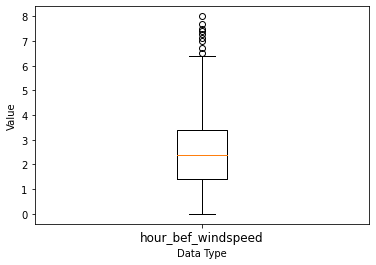

In [35]:
fig, ax = plt.subplots()
ax.boxplot([regression_df['hour_bef_windspeed']])
ax.set_xlabel('Data Type')
ax.set_ylabel('Value')
ax.set_xticklabels(['hour_bef_windspeed'], fontsize=12)
plt.show()

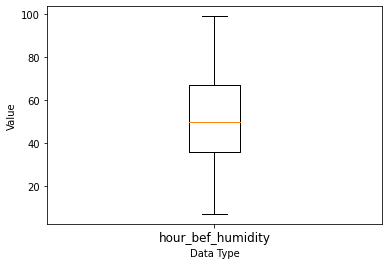

In [36]:
fig, ax = plt.subplots()
ax.boxplot([regression_df['hour_bef_humidity']])
ax.set_xlabel('Data Type')
ax.set_ylabel('Value')
ax.set_xticklabels(['hour_bef_humidity'], fontsize=12)
plt.show()

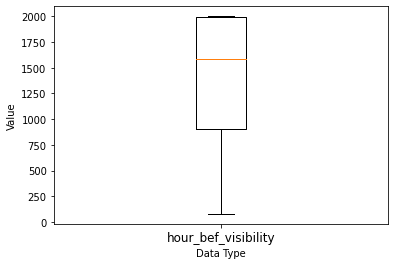

In [38]:
fig, ax = plt.subplots()
ax.boxplot([regression_df['hour_bef_visibility']])
ax.set_xlabel('Data Type')
ax.set_ylabel('Value')
ax.set_xticklabels(['hour_bef_visibility'], fontsize=12)
plt.show()

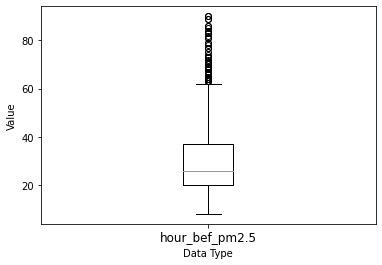

In [39]:
fig, ax = plt.subplots()
ax.boxplot([regression_df['hour_bef_pm2.5']])
ax.set_xlabel('Data Type')
ax.set_ylabel('Value')
ax.set_xticklabels(['hour_bef_pm2.5'], fontsize=12)
plt.show()

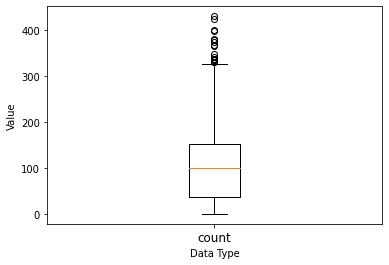

In [40]:
fig, ax = plt.subplots()
ax.boxplot([regression_df['count']])
ax.set_xlabel('Data Type')
ax.set_ylabel('Value')
ax.set_xticklabels(['count'], fontsize=12)
plt.show()

#### 6. count를 y값, 나머지를 X값으로 처리

In [ ]:
y=pd.DataFrame(regression_df['count'])
y

,count
0,49.0
1,159.0
2,26.0
3,57.0
4,431.0
...,...
1337,21.0
1338,20.0
1339,22.0
1340,216.0


In [ ]:
newdf = regression_df.drop(['count'],axis=1)

In [ ]:
x = pd.DataFrame(newdf)
x

,hour,hour_bef_temperature,hour_bef_precipitation,hour_bef_windspeed,hour_bef_humidity,hour_bef_visibility,hour_bef_ozone,hour_bef_pm10,hour_bef_pm2.5
0,20,16.3,1.0,1.5,89.0,576.0,0.039149,57.168736,33.0
1,13,20.1,0.0,1.4,48.0,916.0,0.039149,57.168736,40.0
2,6,13.9,0.0,0.7,79.0,1382.0,0.039149,57.168736,19.0
3,23,8.1,0.0,2.7,54.0,946.0,0.039149,57.168736,64.0
4,18,29.5,0.0,4.8,7.0,2000.0,0.039149,57.168736,11.0
...,...,...,...,...,...,...,...,...,...
1337,4,16.8,0.0,1.6,53.0,2000.0,0.039149,57.168736,27.0
1338,3,10.8,0.0,3.8,45.0,2000.0,0.039149,57.168736,19.0
1339,5,18.3,0.0,1.9,54.0,2000.0,0.039149,57.168736,21.0
1340,21,20.7,0.0,3.7,37.0,1395.0,0.039149,57.168736,36.0


In [ ]:
# 상수인 column drop
x = x.drop(['hour_bef_ozone','hour_bef_pm10'],axis=1)


#### 7. X와 y의 통계량 출력(describe 함수 사용)

In [ ]:
x.describe()

,hour,hour_bef_temperature,hour_bef_precipitation,hour_bef_windspeed,hour_bef_humidity,hour_bef_visibility,hour_bef_pm2.5
count,1342.000000,1342.000000,1342.000000,1342.000000,1342.000000,1342.000000,1342.000000
mean,11.918778,16.894262,0.029806,2.494188,51.627422,1417.240686,30.327124
std,6.744852,5.195518,0.170116,1.379474,20.144847,576.653123,14.713252
min,0.000000,3.100000,0.000000,0.000000,7.000000,78.000000,8.000000
25%,6.000000,13.100000,0.000000,1.400000,36.000000,904.500000,20.000000
50%,12.000000,16.800000,0.000000,2.400000,50.000000,1587.000000,26.000000
75%,18.000000,20.300000,0.000000,3.400000,67.000000,1994.000000,37.000000
max,23.000000,30.000000,1.000000,8.000000,99.000000,2000.000000,90.000000


In [ ]:
y.describe()

,count
count,1342.000000
mean,111.166915
std,83.021073
min,1.000000
25%,37.000000
50%,101.000000
75%,154.000000
max,431.000000


## 1-2) 다중공선성 확인

#### 1 heatmap을 그리고 이를 통해 상관관계가 제일 큰 두개의 변수 중 종속변수(y)와 상관관계가 더 낮은 변수 제거
* 이때 하나의 변수가 제거된 X를 X2로 새로 지정

In [ ]:
x.corr()

,hour,hour_bef_temperature,hour_bef_precipitation,hour_bef_windspeed,hour_bef_humidity,hour_bef_visibility,hour_bef_pm2.5
hour,1.000000,0.402386,0.021609,0.459823,-0.324711,0.193399,-0.061229
hour_bef_temperature,0.402386,1.000000,-0.095737,0.370793,-0.486215,0.200341,-0.078665
hour_bef_precipitation,0.021609,-0.095737,1.000000,0.011543,0.264583,-0.196813,0.004742
hour_bef_windspeed,0.459823,0.370793,0.011543,1.000000,-0.427852,0.261902,-0.198391
hour_bef_humidity,-0.324711,-0.486215,0.264583,-0.427852,1.000000,-0.594545,0.167736
hour_bef_visibility,0.193399,0.200341,-0.196813,0.261902,-0.594545,1.000000,-0.644989
hour_bef_pm2.5,-0.061229,-0.078665,0.004742,-0.198391,0.167736,-0.644989,1.000000


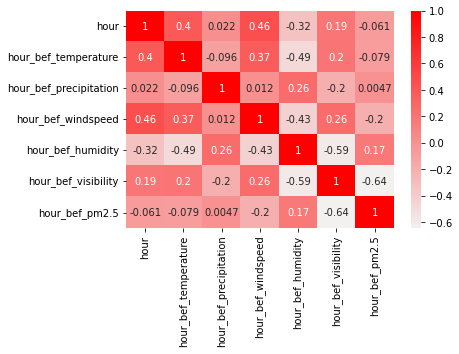

In [ ]:
cmap = sns.light_palette(color="red", as_cmap=True)
sns.heatmap(x.corr(), annot=True, cmap=cmap)
plt.show()

In [ ]:
# hour_bef_visibility와 hour_bef_pm2.5중 y와 corr 낮은 col 삭제
regression_df.corr()['count']

hour                      0.622092
hour_bef_temperature      0.610744
hour_bef_precipitation   -0.159124
hour_bef_windspeed        0.458143
hour_bef_humidity        -0.461788
hour_bef_visibility       0.306605
hour_bef_ozone                 NaN
hour_bef_pm10                  NaN
hour_bef_pm2.5           -0.134293
count                     1.000000
Name: count, dtype: float64

In [ ]:
x2 = x.drop(['hour_bef_pm2.5'],axis=1)

#### 2 VIF를 통해 다중공선성 위험이 제일 큰 변수 한개를 제거
* 이때 X가 아닌 heatmap을 통해 변수 한개를 제거한 X2를 통해 VIF 계산
* 변수 제거 후에는 X3로 새로 지정


In [ ]:
x2.corr()

,hour,hour_bef_temperature,hour_bef_precipitation,hour_bef_windspeed,hour_bef_humidity,hour_bef_visibility
hour,1.000000,0.402386,0.021609,0.459823,-0.324711,0.193399
hour_bef_temperature,0.402386,1.000000,-0.095737,0.370793,-0.486215,0.200341
hour_bef_precipitation,0.021609,-0.095737,1.000000,0.011543,0.264583,-0.196813
hour_bef_windspeed,0.459823,0.370793,0.011543,1.000000,-0.427852,0.261902
hour_bef_humidity,-0.324711,-0.486215,0.264583,-0.427852,1.000000,-0.594545
hour_bef_visibility,0.193399,0.200341,-0.196813,0.261902,-0.594545,1.000000


In [ ]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

vif = pd.DataFrame()
vif["features"] = x2.columns
vif["VIF Factor"] = [variance_inflation_factor(x2.values, i) for i in range(x2.shape[1])]
vif

,features,VIF Factor
0,hour,5.714087
1,hour_bef_temperature,11.059110
2,hour_bef_precipitation,1.130676
3,hour_bef_windspeed,5.946416
4,hour_bef_humidity,3.689079
5,hour_bef_visibility,6.361516


In [ ]:
x3 = x2.drop(['hour_bef_temperature'],axis=1)

In [ ]:
vif = pd.DataFrame()
vif["features"] = x3.columns
vif["VIF Factor"] = [variance_inflation_factor(x3.values, i) for i in range(x3.shape[1])]
vif

,features,VIF Factor
0,hour,5.037171
1,hour_bef_precipitation,1.122114
2,hour_bef_windspeed,5.395633
3,hour_bef_humidity,3.021490
4,hour_bef_visibility,5.242690


#### 3 heatmap, VIF를 통해 다중공선성이 제거된 데이터로 statsmodel을 통해 summary 출력

In [ ]:
lin_model_1 = sm.OLS(y,x3)
lin_model_1 = lin_model_1.fit()

In [ ]:
lin_model_1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                  count   R-squared (uncentered):                   0.814
Model:                            OLS   Adj. R-squared (uncentered):              0.813
Method:                 Least Squares   F-statistic:                              1168.
Date:                Thu, 06 Oct 2022   Prob (F-statistic):                        0.00
Time:                        15:16:23   Log-Likelihood:                         -7396.3
No. Observations:                1342   AIC:                                  1.480e+04
Df Residuals:                    1337   BIC:                                  1.483e+04
Df Model:                           5                                                  
Covariance Type:            nonrobust                                                  
==========================================================================================
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
hour                       6.3595      0.268     23.691      0.000       5.833       6.886
hour_bef_precipitation   -61.4523     10.049     -6.115      0.000     -81.166     -41.738
hour_bef_windspeed        10.9442      1.335      8.199      0.000       8.326      13.563
hour_bef_humidity         -0.3126      0.051     -6.085      0.000      -0.413      -0.212
hour_bef_visibility        0.0176      0.002      7.176      0.000       0.013       0.022
==============================================================================
Omnibus:                      146.256   Durbin-Watson:                   1.958
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              220.335
Skew:                           0.786   Prob(JB):                     1.43e-48
Kurtosis:                       4.212   Cond. No.                     9.39e+03
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[3] The condition number is large, 9.39e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""